## Retail Store Sales Forecasting with Neural Networks
### By Yasaman Ensafi

## Import libraries

In [638]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
matplotlib.style.use('ggplot')
%matplotlib inline
from statsmodels.graphics import tsaplots
import statsmodels.api as sm
from pylab import rcParams

import plotly as py
import plotly.express as px
import plotly.graph_objs as go 
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

## Load Dataset

In [639]:
data= pd.read_excel('MRP_data.xls')

## Exploratory Data Analysis (EDA)

In [640]:
data.head(n=2)

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.96,2,0.0,41.9136
1,2,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.94,3,0.0,219.5820


In [641]:
data.describe()

,Row ID,Postal Code,Sales,Quantity,Discount,Profit
count,9994.000000,9994.000000,9994.000000,9994.000000,9994.000000,9994.000000
mean,4997.500000,55190.379428,229.858001,3.789574,0.156203,28.656896
std,2885.163629,32063.693350,623.245101,2.225110,0.206452,234.260108
min,1.000000,1040.000000,0.444000,1.000000,0.000000,-6599.978000
25%,2499.250000,23223.000000,17.280000,2.000000,0.000000,1.728750
50%,4997.500000,56430.500000,54.490000,3.000000,0.200000,8.666500
75%,7495.750000,90008.000000,209.940000,5.000000,0.200000,29.364000
max,9994.000000,99301.000000,22638.480000,14.000000,0.800000,8399.976000


### Missing Data

In [642]:
data.info()
# We can see that there is no missing value

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9994 entries, 0 to 9993
Data columns (total 21 columns):
Row ID           9994 non-null int64
Order ID         9994 non-null object
Order Date       9994 non-null datetime64[ns]
Ship Date        9994 non-null datetime64[ns]
Ship Mode        9994 non-null object
Customer ID      9994 non-null object
Customer Name    9994 non-null object
Segment          9994 non-null object
Country          9994 non-null object
City             9994 non-null object
State            9994 non-null object
Postal Code      9994 non-null int64
Region           9994 non-null object
Product ID       9994 non-null object
Category         9994 non-null object
Sub-Category     9994 non-null object
Product Name     9994 non-null object
Sales            9994 non-null float64
Quantity         9994 non-null int64
Discount         9994 non-null float64
Profit           9994 non-null float64
dtypes: datetime64[ns](2), float64(3), int64(3), object(13)
memory usage: 1.6+ 

In [643]:
#Shape
data.shape

(9994, 21)

In [644]:
data.columns

Index(['Row ID', 'Order ID', 'Order Date', 'Ship Date', 'Ship Mode',
       'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State',
       'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category',
       'Product Name', 'Sales', 'Quantity', 'Discount', 'Profit'],
      dtype='object')

### Edit columns names

In [645]:
# Lower case column names
data.columns = map(str.lower, data.columns)
#Replace spaces with '_'
data.columns = data.columns.str.replace(" ", "_")
data.columns = data.columns.str.replace("-", "_")
data.columns

Index(['row_id', 'order_id', 'order_date', 'ship_date', 'ship_mode',
       'customer_id', 'customer_name', 'segment', 'country', 'city', 'state',
       'postal_code', 'region', 'product_id', 'category', 'sub_category',
       'product_name', 'sales', 'quantity', 'discount', 'profit'],
      dtype='object')

### Check the unique values of columns

In [646]:
for c in data.columns:
    if len(set(data[c]))<20:
        print(c,set(data[c]))

ship_mode {'Standard Class', 'Second Class', 'Same Day', 'First Class'}
segment {'Consumer', 'Home Office', 'Corporate'}
country {'United States'}
region {'West', 'Central', 'South', 'East'}
category {'Office Supplies', 'Technology', 'Furniture'}
sub_category {'Chairs', 'Labels', 'Storage', 'Tables', 'Phones', 'Art', 'Paper', 'Accessories', 'Copiers', 'Furnishings', 'Supplies', 'Fasteners', 'Machines', 'Appliances', 'Envelopes', 'Bookcases', 'Binders'}
quantity {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14}
discount {0.0, 0.8, 0.2, 0.3, 0.45, 0.5, 0.7, 0.6, 0.32, 0.1, 0.4, 0.15}


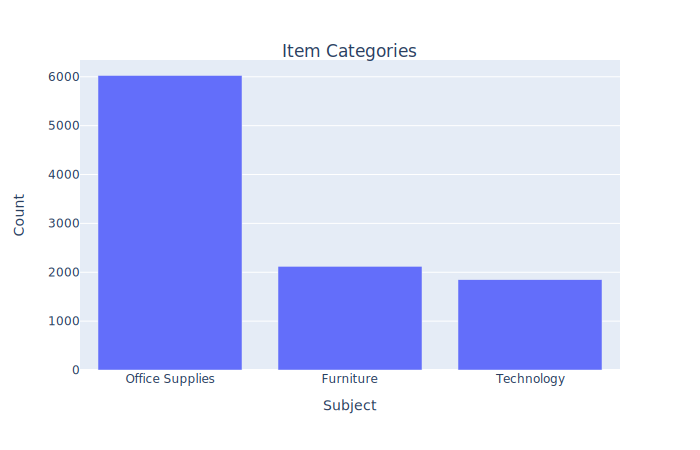

In [647]:
a = data['category'].value_counts()
fig = px.bar(a, x=a.index, y=a.values, height=400)
fig.update_layout( title={
        'text': "Item Categories",
        'y':0.9,'x':0.5,'xanchor': 'center','yanchor': 'top'},
    xaxis_title="Subject",
    yaxis_title="Count")
fig.show(renderer='svg')

### Separating data by the category (Furniture, Technology, Office Supplies)

In [648]:
df_furniture=data.loc[data['category'] == 'Furniture']
df_technology=data.loc[data['category'] == 'Technology']
df_office=data.loc[data['category'] == 'Office Supplies']

In [649]:
#Aggregating sales by order date
furniture= df_furniture.groupby('order_date')['sales'].sum().reset_index()
technology= df_technology.groupby('order_date')['sales'].sum().reset_index()
office= df_office.groupby('order_date')['sales'].sum().reset_index()

In [650]:
#Set index 
furniture = furniture.set_index('order_date')
technology = technology.set_index('order_date')
office = office.set_index('order_date')

#set index for original datasets
df_furniture = df_furniture.set_index('order_date')
df_technology = df_technology.set_index('order_date')
df_office = df_office.set_index('order_date')

In [651]:
furniture.index

DatetimeIndex(['2014-01-06', '2014-01-07', '2014-01-10', '2014-01-11',
               '2014-01-13', '2014-01-14', '2014-01-16', '2014-01-19',
               '2014-01-20', '2014-01-21',
               ...
               '2017-12-18', '2017-12-19', '2017-12-21', '2017-12-22',
               '2017-12-23', '2017-12-24', '2017-12-25', '2017-12-28',
               '2017-12-29', '2017-12-30'],
              dtype='datetime64[ns]', name='order_date', length=889, freq=None)

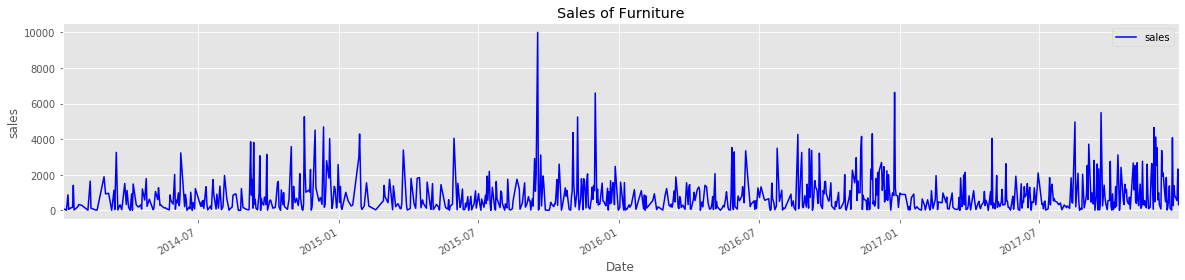

In [652]:
furniture_sales = furniture[['sales']]
furniture_sales.plot(color='blue',figsize=(20,4))
plt.xlabel("Date")
plt.ylabel('sales')
plt.title("Sales of Furniture")
plt.show()

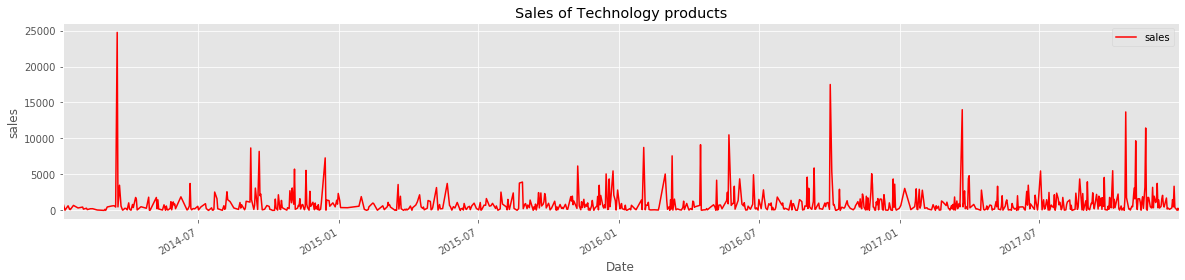

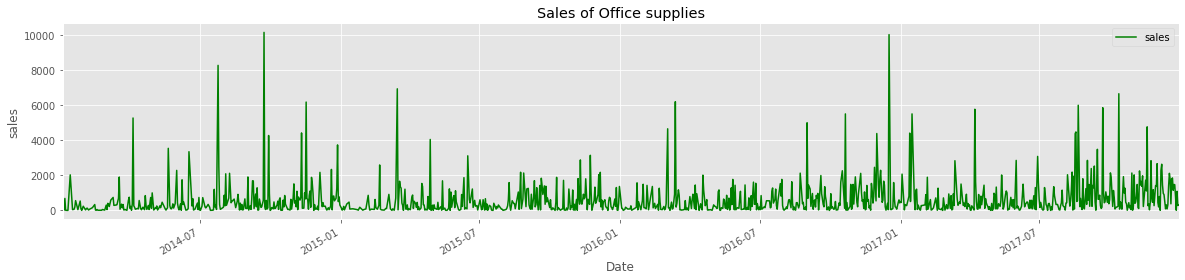

In [653]:
technology_sales = technology[['sales']]
ax= technology_sales.plot(color='r',figsize=(20,4))
plt.xlabel("Date")
plt.ylabel('sales')
plt.title("Sales of Technology products")
plt.show()

office_sales = office[['sales']]
ax= office_sales.plot(color='green',figsize=(20,4))
ax.set_xlabel("Date")
ax.set_ylabel('sales')
ax.set_title("Sales of Office supplies")
plt.show()

In [654]:
# Using averages daily sales value - set start of the month as index
avg_furniture_sales = furniture_sales['sales'].resample('MS').mean()
avg_technology_sales = technology_sales['sales'].resample('MS').mean()
avg_office_sales = office_sales['sales'].resample('MS').mean()

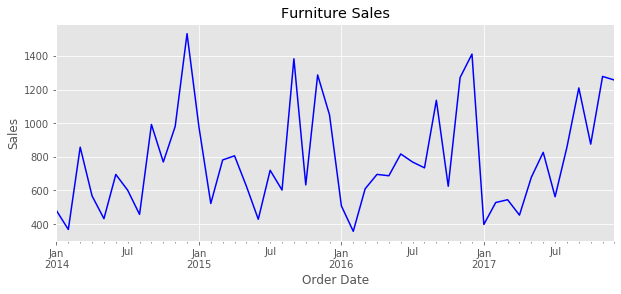

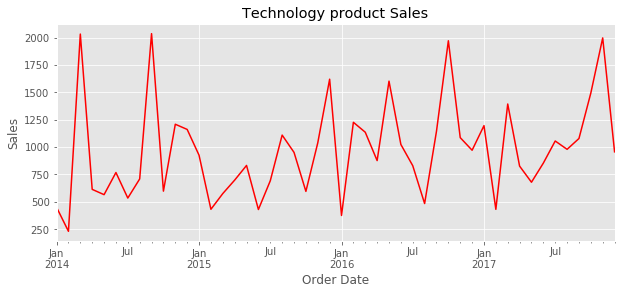

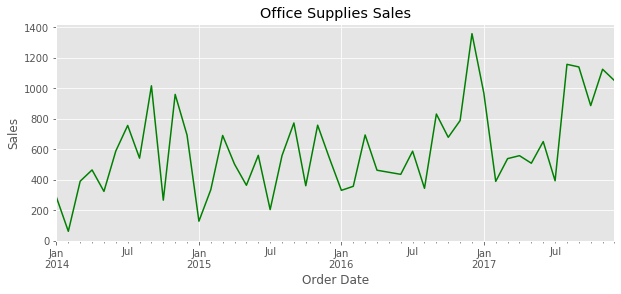

In [655]:
avg_furniture_sales.plot(figsize=(10, 4),color='blue')
plt.xlabel("Order Date")
plt.ylabel('Sales')
plt.title("Furniture Sales")
plt.show()

avg_technology_sales.plot(figsize=(10, 4),color='red')
plt.xlabel("Order Date")
plt.ylabel('Sales')
plt.title("Technology product Sales")
plt.show()

avg_office_sales.plot(figsize=(10, 4),color='green')
plt.xlabel("Order Date")
plt.ylabel('Sales')
plt.title("Office Supplies Sales")
plt.show()

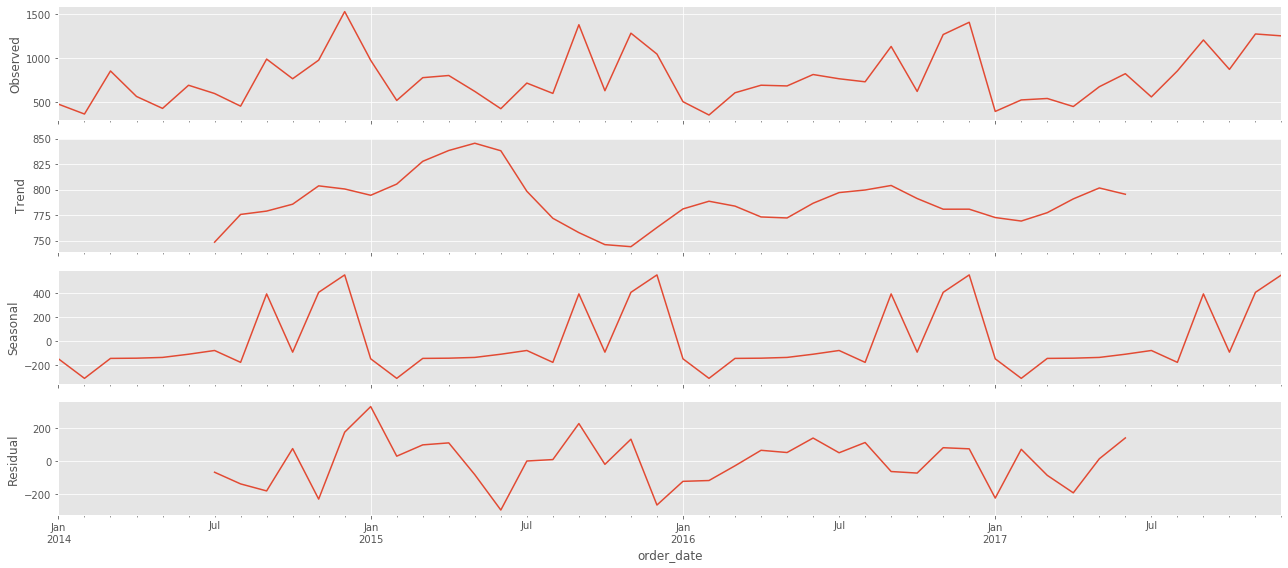

In [606]:
#Furniture sales time-series decomposition
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(avg_furniture_sales, model='additive')
fig = decomposition.plot()
plt.show()

### Plot the map of states based on the amount of sales

In [607]:
states_profit = df_furniture.groupby('state').sum()['sales']
states_profit_df = pd.DataFrame(data=states_profit,columns=['sales']).reset_index()

In [608]:
us_state_abbrev = {
    'Alabama': 'AL','Alaska': 'AK','American Samoa': 'AS','Arizona': 'AZ','Arkansas': 'AR','California': 'CA',
    'Colorado': 'CO','Connecticut': 'CT','Delaware': 'DE','District of Columbia': 'DC','Florida': 'FL',
    'Georgia': 'GA','Guam': 'GU','Hawaii': 'HI','Idaho': 'ID','Illinois': 'IL','Indiana': 'IN','Iowa': 'IA',
    'Kansas': 'KS','Kentucky': 'KY','Louisiana': 'LA','Maine': 'ME','Maryland': 'MD','Massachusetts': 'MA',
    'Michigan': 'MI','Minnesota': 'MN','Mississippi': 'MS','Missouri': 'MO','Montana': 'MT','Nebraska': 'NE',
    'Nevada': 'NV','New Hampshire': 'NH','New Jersey': 'NJ','New Mexico': 'NM','New York': 'NY',
    'North Carolina': 'NC','North Dakota': 'ND','Northern Mariana Islands':'MP','Ohio': 'OH','Oklahoma': 'OK',
    'Oregon': 'OR','Pennsylvania': 'PA','Puerto Rico': 'PR','Rhode Island': 'RI','South Carolina': 'SC',
    'South Dakota': 'SD','Tennessee': 'TN','Texas': 'TX','Utah': 'UT','Vermont': 'VT','Virgin Islands': 'VI',
    'Virginia': 'VA','Washington': 'WA','West Virginia': 'WV','Wisconsin': 'WI','Wyoming': 'WY'
}

In [609]:
list_abv = []
for state in states_profit_df['state']:
    list_abv.append(us_state_abbrev[state])

In [610]:
states_profit_df['code']=list_abv

In [611]:
#Set up everything so that the figures show up in the notebook
init_notebook_mode(connected=True) 

In [612]:
state_data = dict(type='choropleth',
            colorscale = 'RdBu',
            locations = states_profit_df['code'],
            z = np.round(states_profit_df['sales'],2),
            locationmode = 'USA-states',
            text = states_profit_df['state'],
            marker = dict(line = dict(color = 'rgb(255,255,255)',width = 2)),
            colorbar = {'title':"USD"}
            ) 

In [613]:
layout = dict(title='Map of the States based on the amount of sales',geo = {'scope':'usa'})

In [614]:
choromap = go.Figure(data = [state_data],layout = layout)

In [659]:
iplot(choromap)

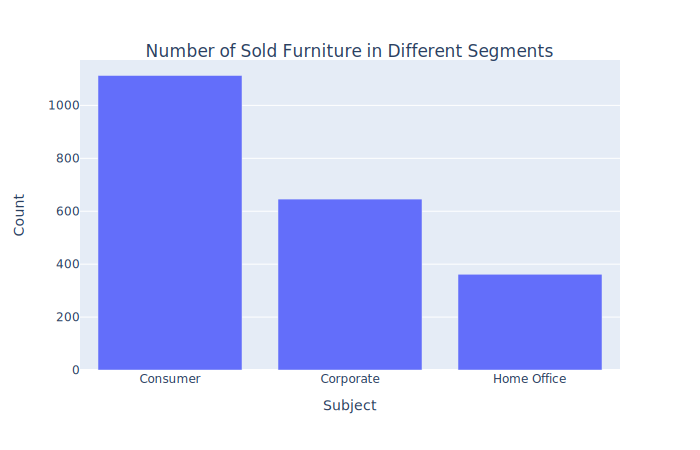

In [660]:
b = df_furniture['segment'].value_counts()
fig = px.bar(b, x=b.index, y=b.values, height=400)
fig.update_layout( title={
        'text': "Number of Sold Furniture in Different Segments",
        'y':0.9,'x':0.5,'xanchor': 'center','yanchor': 'top'},
    xaxis_title="Subject",
    yaxis_title="Count")
fig.show(renderer='svg')

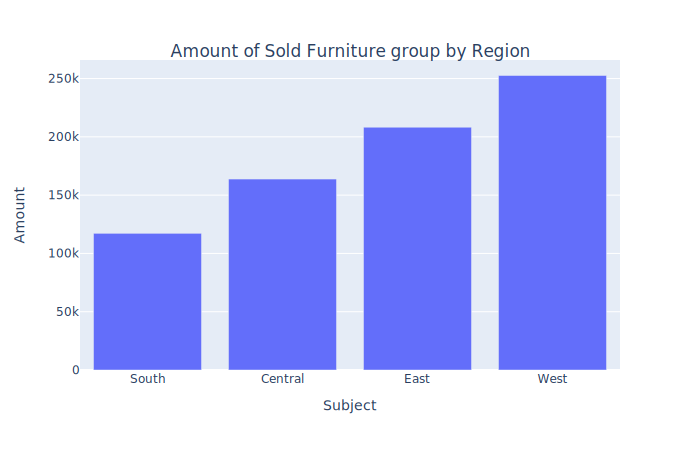

In [661]:
c = df_furniture.groupby('region')['sales'].sum().sort_values()
fig = px.bar(c, x=c.index, y=c.values, height=400)
fig.update_layout( title={
        'text': "Amount of Sold Furniture group by Region",
        'y':0.9,'x':0.5,'xanchor': 'center','yanchor': 'top'},
    xaxis_title="Subject",
    yaxis_title="Amount")
fig.show(renderer='svg')

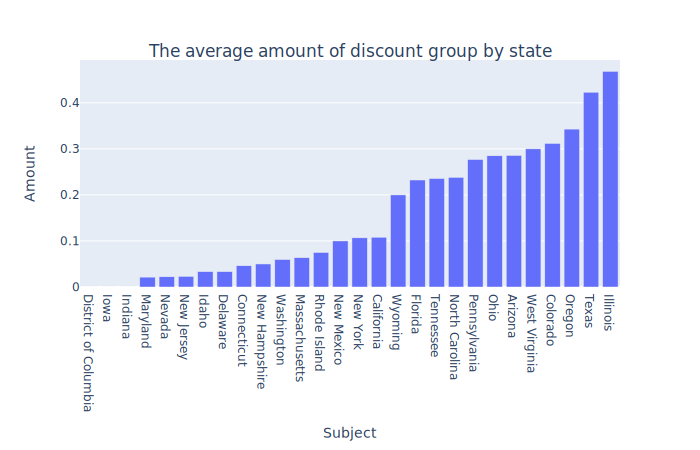

In [662]:
d = df_furniture.groupby('state')['discount'].mean().sort_values()[-28:]
fig = px.bar(d, x=d.index, y=d.values, height=400)
fig.update_layout( title={
        'text': "The average amount of discount group by state",
        'y':0.9,'x':0.5,'xanchor': 'center','yanchor': 'top'},
    xaxis_title="Subject",
    yaxis_title="Amount")
fig.show(renderer='svg')

The graph below shows the number of sales group by region separated by category. In all of the regions products in office supplies category were the bes seller and products in the furniture category sold less than others.

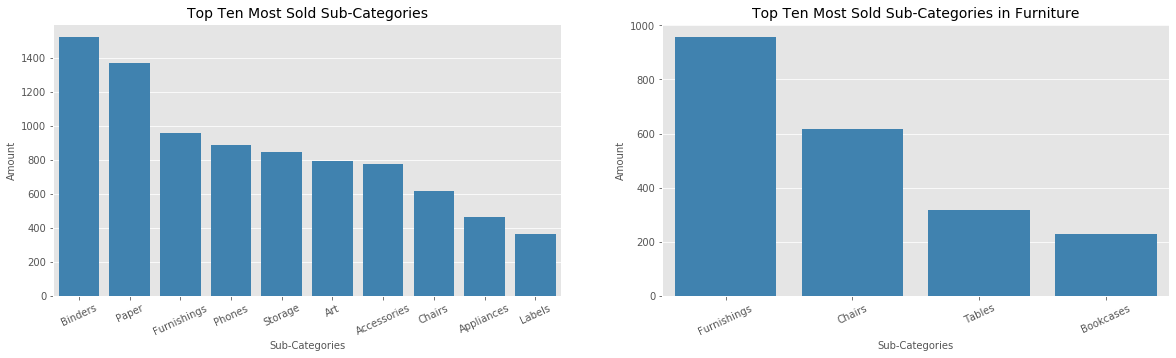

In [663]:
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
sns.barplot(x=data['sub_category'].value_counts().sort_values(ascending=False)[:10].index,
           y=data['sub_category'].value_counts().sort_values(ascending=False)[:10].values,color='#2E86C1')
plt.title('Top Ten Most Sold Sub-Categories',size=14)
plt.xticks(rotation='25')
plt.xlabel('Sub-Categories',size=10)
plt.ylabel('Amount',size=10)

plt.subplot(1,2,2)
sns.barplot(x=df_furniture['sub_category'].value_counts().sort_values(ascending=False)[:10].index,
           y=df_furniture['sub_category'].value_counts().sort_values(ascending=False)[:10].values,color='#2E86C1')
plt.title('Top Ten Most Sold Sub-Categories in Furniture',size=14)
plt.xticks(rotation='25')
plt.xlabel('Sub-Categories',size=10)
plt.ylabel('Amount',size=10)

plt.show()

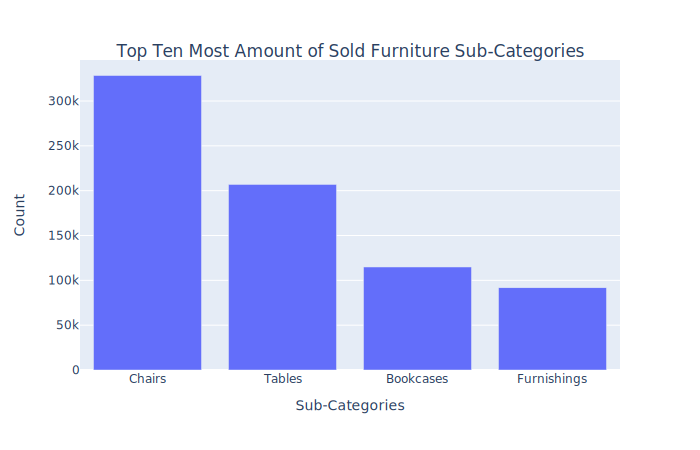

In [664]:
f = df_furniture.groupby('sub_category')['sales'].sum().sort_values(ascending=False)
fig = px.bar(f, x=f.index, y=f.values, height=400)
fig.update_layout( title={
        'text': "Top Ten Most Amount of Sold Furniture Sub-Categories",
        'y':0.9,'x':0.5,'xanchor': 'center','yanchor': 'top'},
    xaxis_title="Sub-Categories",
    yaxis_title="Count")
fig.show(renderer='svg')

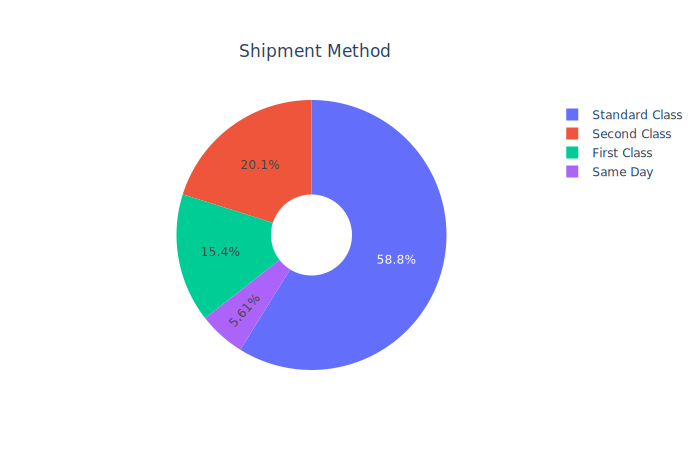

In [670]:
g= df_furniture['ship_mode'].value_counts()

labels = g.index
values = g.values


# Use `hole` to create a donut-like pie chart
fig = go.Figure(data=[go.Pie(labels=labels, values=values, hole=.3)])
fig.update_layout( title={
        'text': "Shipment Method",
        'y':0.9,'x':0.45,'xanchor': 'center','yanchor': 'top'})
fig.show(renderer='svg')

In [671]:
#total quantity of products on this file
data['quantity'].sum()

37873

In [672]:
#Quantity grouped by region
data.groupby(['region'])['quantity'].sum()

region
Central     8780
East       10618
South       6209
West       12266
Name: quantity, dtype: int64

The bellow heat map graph, indicate the positive and negative correlation between variables.
There is a negative correlation between discount and profit. 

(6.0, 0.0)

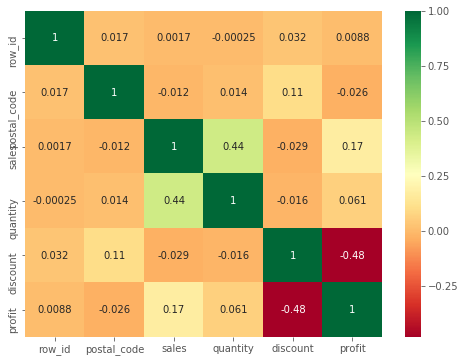

In [673]:
df_corr = df_furniture.corr()
plt.figure(figsize=(8,6))
ax = sns.heatmap(df_corr, annot=True,cmap='RdYlGn') #notation: "annot" not "annote"
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

## Data Preprossesing

In [674]:
df_furniture.head(2)

,row_id,order_id,order_date,ship_date,ship_mode,customer_id,customer_name,segment,country,city,...,postal_code,region,product_id,category,sub_category,product_name,sales,quantity,discount,profit
0,1,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.96,2,0.0,41.9136
1,2,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.94,3,0.0,219.5820


In [675]:
# We don't need row_id, order_id,customer information
# Also we don't need the country and category column (there is only one value for them)

df_furniture=df_furniture.drop('row_id',axis=1)
df_furniture=df_furniture.drop('order_id',axis=1)
df_furniture=df_furniture.drop('customer_id',axis=1)
df_furniture=df_furniture.drop('customer_name',axis=1)
df_furniture=df_furniture.drop('country',axis=1)
df_furniture=df_furniture.drop('category',axis=1)
df_furniture=df_furniture.drop('product_id',axis=1)
df_furniture=df_furniture.drop('product_name',axis=1)

In [676]:
# We are going to use order date and not ship date
df_furniture=df_furniture.drop('ship_date',axis=1)

In [677]:
#Convert the ship_mode into dummy variables
dummies = pd.get_dummies(df_furniture['ship_mode'],drop_first=True)
df_furniture= pd.concat( [df_furniture.drop('ship_mode',axis=1),dummies],axis=1)

In [678]:
#Convert the segment into dummy variables
dummies2 = pd.get_dummies(df_furniture['segment'],drop_first=True)
df_furniture= pd.concat( [df_furniture.drop('segment',axis=1),dummies2],axis=1)

In [679]:
#Convert the region into dummy variables
dummies3 = pd.get_dummies(df_furniture['region'],drop_first=True)
df_furniture= pd.concat( [df_furniture.drop('region',axis=1),dummies3],axis=1)

In [680]:
# Too many unique job city to convert it to dummy variables. So we remove the city column.
print(len(set(df_furniture['city'])))
# We are going to use order date and not ship date
df_furniture=df_furniture.drop('city',axis=1)

371


In [681]:
#Convert the sub_category into dummy variables
dummies4 = pd.get_dummies(df_furniture['sub_category'],drop_first=True)
df_furniture= pd.concat( [df_furniture.drop('sub_category',axis=1),dummies4],axis=1)

In [682]:
# Too many unique city to convert it to dummy variables. So we remove the city column.
print(len(set(df_furniture['postal_code'])))
# We are going to use order date and not ship date
df_furniture=df_furniture.drop('postal_code',axis=1)

454


In [683]:
# Too many unique state to convert it to dummy variables. So we remove the city column.
print(len(set(df_furniture['state'])))
# We are going to use order date and not ship date
df_furniture=df_furniture.drop('state',axis=1)

48


In [684]:
df_furniture.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2121 entries, 0 to 9990
Data columns (total 16 columns):
order_date        2121 non-null datetime64[ns]
sales             2121 non-null float64
quantity          2121 non-null int64
discount          2121 non-null float64
profit            2121 non-null float64
Same Day          2121 non-null uint8
Second Class      2121 non-null uint8
Standard Class    2121 non-null uint8
Corporate         2121 non-null uint8
Home Office       2121 non-null uint8
East              2121 non-null uint8
South             2121 non-null uint8
West              2121 non-null uint8
Chairs            2121 non-null uint8
Furnishings       2121 non-null uint8
Tables            2121 non-null uint8
dtypes: datetime64[ns](1), float64(3), int64(1), uint8(11)
memory usage: 122.2 KB


In [685]:
df_furniture = df_furniture.sort_values('order_date').set_index('order_date')
df_furniture.head()

,sales,quantity,discount,profit,Same Day,Second Class,Standard Class,Corporate,Home Office,East,South,West,Chairs,Furnishings,Tables
order_date,,,,,,,,,,,,,,,
2014-01-06,2573.820,9,0.0,746.4078,0,0,1,0,1,0,1,0,1,0,0
2014-01-07,76.728,3,0.6,-53.7096,0,0,1,0,0,0,0,0,0,1,0
2014-01-10,51.940,1,0.0,21.2954,0,0,1,1,0,0,1,0,0,1,0
2014-01-11,9.940,2,0.0,3.0814,0,0,0,0,0,1,0,0,0,1,0
2014-01-13,545.940,6,0.0,87.3504,0,1,0,0,0,0,1,0,1,0,0
